In [1]:
%matplotlib nbagg
from __future__ import print_function

import os
import datetime as dt
import platform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.dates import num2date, DateFormatter, hours
from matplotlib.backends.backend_pdf import PdfPages
from scipy.io import readsav
from sunpy.lightcurve import GOESLightCurve, LightCurve
from sunpy.time import TimeRange
from hekar import HEK
from getrstn import GetRSTN

from utils import (
    onclick, posicao, calculo_de_indice,
    load_dados, calculo_da_media, CAMINHO_ABSOLUTO,
    ponto_mais_proximo
)

c:\users\inpe-craam\appdata\local\programs\python\python36-32\lib\site-packages\sunpy\lightcurve\__init__.py:18: SunpyDeprecationWarning: As of v0.8.0, the `sunpy.lightcurve` module is deprecated and will be removed in a future version. Use `sunpy.timeseries` or `sunpy.map` for coordinate transformations.
  _SunpyDeprecationWarning)


In [2]:
filename = '01110209'
df, time, diretorio, data = load_dados('2002', filename)
if platform.system() == "Linux":
    pdf = PdfPages(CAMINHO_ABSOLUTO + diretorio + "/Graficos.pdf")
else:
    pdf = PdfPages(CAMINHO_ABSOLUTO + diretorio + "\\Graficos.pdf")

O diretorio já existe


<IPython.core.display.Javascript object>


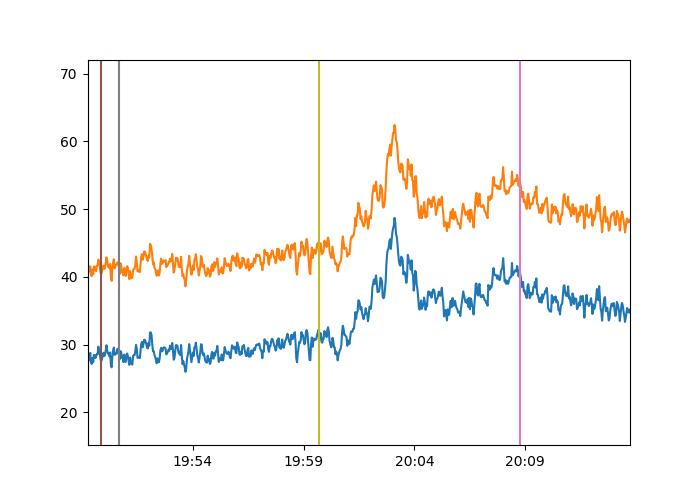

7

In [3]:
# Faz as médias
plt.rcParams['figure.figsize'] = 7,5
fig1, axis = plt.subplots()

# Usa o mesmo index do dataframe para o eixo x.

axis.plot(df.index, df)
axis.xaxis.set_major_formatter(DateFormatter('%H:%M'))
fig1.canvas.mpl_connect('button_press_event', onclick)

In [4]:
"""
 Ordem de seleção:
  Os dois últimos (últimos) selecionados são usados para o calculo das médias.
  Os dois penúltimos (primeiros) selecionados são usados para representar a média
  no grafico.
"""
dados_da_media = calculo_da_media(df)

indice_ig1 = dados_da_media[0]
indice_ig2 = dados_da_media[1]
medias = dados_da_media[2]
media_final_r = medias['R']
media_final_l = medias['L']
tempo1_flare = dados_da_media[3]
tempo2_flare = dados_da_media[4]

<IPython.core.display.Javascript object>


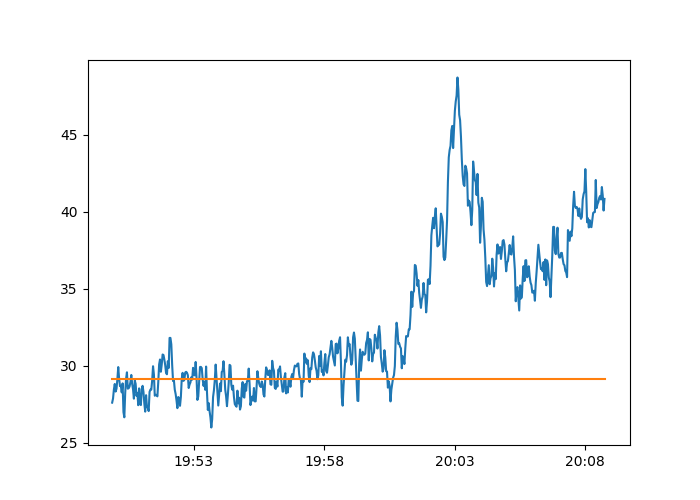

<IPython.core.display.Javascript object>


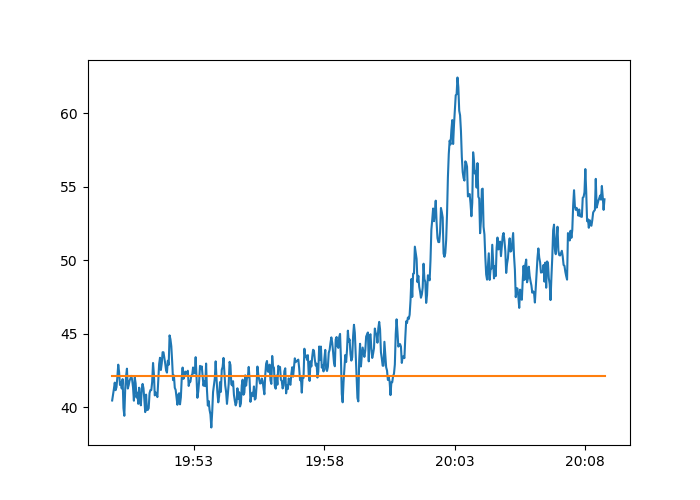

In [5]:
fig_R, axis = plt.subplots()
# Usa o mesmo index do dataframe para o eixo x.
axis.plot(df.index[tempo1_flare:tempo2_flare], df["R"][tempo1_flare:tempo2_flare])
axis.xaxis.set_major_formatter(DateFormatter('%H:%M'))

plt.plot([df.index[tempo1_flare], df.index[tempo2_flare]],[media_final_r, media_final_r])

fig_L, axis = plt.subplots()
# Usa o mesmo index do dataframe para o eixo x.
axis.plot(df.index[tempo1_flare:tempo2_flare], df["L"][tempo1_flare:tempo2_flare])
axis.xaxis.set_major_formatter(DateFormatter('%H:%M'))

plt.plot([df.index[tempo1_flare], df.index[tempo2_flare]],[media_final_l, media_final_l])

<IPython.core.display.Javascript object>


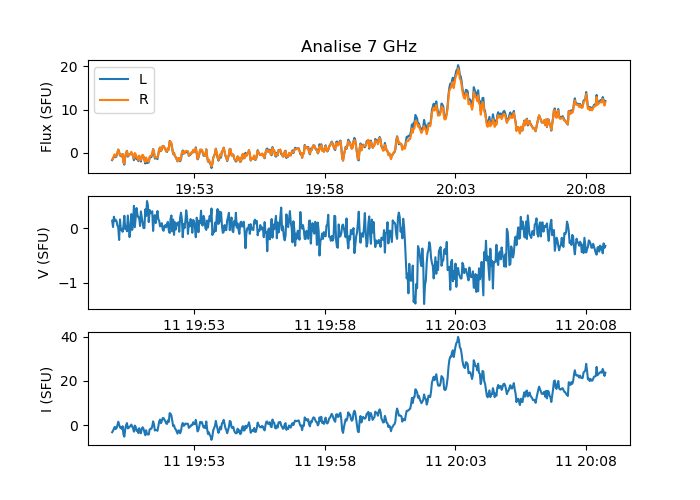

In [6]:
LM_normalizado = df["L_normalizado"][tempo1_flare:tempo2_flare]
RM_normalizado = df["R_normalizado"][tempo1_flare:tempo2_flare]

RL_V = df["R_normalizado"][tempo1_flare:tempo2_flare] - df["L_normalizado"][tempo1_flare:tempo2_flare]
RL_I = df["L_normalizado"][tempo1_flare:tempo2_flare] + df["R_normalizado"][tempo1_flare:tempo2_flare]

fig2, (axis, ax, ax2) = plt.subplots(3)
# Usa o mesmo index do dataframe para o eixo x.
axis.plot(df.index[tempo1_flare:tempo2_flare], LM_normalizado, label="L")
axis.plot(df.index[tempo1_flare:tempo2_flare], RM_normalizado, label="R")
axis.set_title("Analise 7 GHz")
axis.legend()
axis.set_ylabel("Flux (SFU)")

ax.plot(df.index[tempo1_flare:tempo2_flare], RL_V)
ax.set_ylabel("V (SFU)")

ax2.plot(df.index[tempo1_flare:tempo2_flare], RL_I)
ax2.set_ylabel("I (SFU)")
axis.xaxis.set_major_formatter(DateFormatter('%H:%M'))
pico_7ghz = max(RL_I)

# Salva o gráfico.
nome_do_arquivo = "I-V-Flux(SFU)"
if platform.system() == "Linux":
    fig2.savefig(CAMINHO_ABSOLUTO + diretorio + "/" + nome_do_arquivo)
else:
    fig2.savefig(CAMINHO_ABSOLUTO + diretorio + "\\" + nome_do_arquivo)
fig2.savefig(pdf, format='pdf')

## RSTN

In [7]:
rstn = GetRSTN(data["dia"], data["mes"], data["ano"], "dados_rstn")
rstn.download_data()
arquivo_rstn = rstn.decompress_file()
if platform.system() == "Linux":
    arquivo_rstn = "dados_rstn/" + arquivo_rstn
else:
    arquivo_rstn = "dados_rstn\\" + arquivo_rstn

Path exists
100% [........................................................] 166451 / 16645111JAN02.K7O.gz


In [8]:
data = np.genfromtxt(arquivo_rstn, delimiter=2*[4]+5*[2]+8*[6], missing_values=515)

# Frequencies in MHz
f4995  = data[:,12] - np.nanmean(data[:,12])
f8800  = data[:,13] - np.nanmean(data[:,13])
f15400 = data[:,14] - np.nanmean(data[:,14])

dados = {
    "f4995": f4995,
    "f8800": f8800,
    "f15400": f15400
}

day = data[:,3]
t = data[:,4] + data[:,5] / 60. + data[:,6] / 3600.         # Time in hours fractions
tg = dt.date(2002,4,9).toordinal() + (day - 9) + hours(t)   # Gregorian time in day fractions
timeg = num2date(tg)

rstnlc = LightCurve.create({"flux15400": dados["f15400"], "flux8800": dados["f8800"], "flux4995": dados["f4995"]}, index=timeg)
fig = rstnlc.peek()
fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>

AttributeError: 'NoneType' object has no attribute 'canvas'

In [ ]:
posicao_inicial_rstn = posicao[-2]
posicao_final_rstn = posicao[-1]

p1 = num2date(posicao_inicial_rstn[0])
p2 = num2date(posicao_final_rstn[0])

f4995  = data[:,12] - np.nanmean(data[:,12])
f8800  = data[:,13] - np.nanmean(data[:,13])
f15400 = data[:,14] - np.nanmean(data[:,14])

dados = {
    "f4995": f4995,
    "f8800": f8800,
    "f15400": f15400
}

df_rstn = pd.DataFrame(dados, index=timeg)

descarte, tempo_inicial = calculo_de_indice(df_rstn, p1)
descarte, tempo_final = calculo_de_indice(df_rstn, p2)

medias = calculo_da_media(df_rstn, True)

fig, axis = plt.subplots()

plt.title("RSTN Normalizado")
for column in df_rstn.columns:
    if len(column) > 11:
        label = column.replace("f", "flux")
        axis.plot(df_rstn.index, df_rstn[column], label=label)

plt.legend()

In [ ]:
#  Pega o indice do tempo do pico no 7ghz para pegar o
# indice no rstn, comparando os horários.

for index, item in enumerate(RL_I):
    if item == pico_7ghz:
        indice_7ghz = index

RL_I.index[indice_7ghz]

tempo_proximo_rstn = ponto_mais_proximo(RL_I.index, RL_I.index[indice_7ghz])
tempo_proximo_rstn = str(tempo_proximo_rstn)[:19]

for index, item in enumerate(df_rstn["f8800_normalizado"]):
    tempo_rstn = str(df_rstn.index[index])[:19]
    tempo_rstn = tempo_rstn[:5] + "01" + tempo_rstn[7:]
    if tempo_proximo_rstn == tempo_rstn:
        print(RL_I.index[indice_7ghz])
        print(df_rstn.index[index])
        indice_rstn = index

## Espectro

In [ ]:
# Define os valores dos picos.
pico_4995 = df_rstn["f4995_normalizado"][indice_rstn]
pico_8800 = df_rstn["f8800_normalizado"][indice_rstn]
pico_15400 = df_rstn["f15400_normalizado"][indice_rstn]

picos = {
    "4.995": pico_4995,
    "7.0": pico_7ghz,
    "8.8": pico_8800,
    "15.4": pico_15400
}

# Colocar os picos em ordem.
picos_ordenados = [float(x) for x in picos.keys()]

fig, axis = plt.subplots()

for column in sorted(picos_ordenados):
    axis.loglog(column*10**9, picos[str(column)], '-o', label=column)

axis.set_xlabel("Freq.")
plt.title("Espectro")
plt.legend()

nome_do_arquivo = "espectro"
if platform.system() == "Linux":
    caminho = CAMINHO_ABSOLUTO + diretorio + "/" + nome_do_arquivo
else:
    caminho = CAMINHO_ABSOLUTO + diretorio + "\\" + nome_do_arquivo
fig.savefig(caminho)
fig.savefig(pdf, format="pdf")

## Curva de luz GOES

In [9]:
comeco_flare = str(df.index[tempo1_flare])
fim_flare = str(df.index[tempo2_flare])

comeco_flare = comeco_flare[0:19].replace('-', '/')
fim_flare = fim_flare[0:19].replace('-', '/')

tr = TimeRange(comeco_flare, fim_flare)
goes = GOESLightCurve.create(tr)

c:\users\inpe-craam\appdata\local\programs\python\python36-32\lib\site-packages\sunpy\lightcurve\lightcurve.py:292: RuntimeWarning: Using existing file rather than downloading, use overwrite=True to override.
  "overwrite=True to override.", RuntimeWarning)


In [ ]:
fig = goes.peek()

deriv = np.gradient(goes.data['xrsa'])

nome_do_arquivo = "GOES"
# Salvar gráfico.
if platform.system() == "Linux":
    fig.savefig(CAMINHO_ABSOLUTO + diretorio + "/" + nome_do_arquivo)
else:
    fig.savefig(CAMINHO_ABSOLUTO + diretorio + "\\" + nome_do_arquivo)
fig.savefig(pdf, format="pdf")

## Região Ativa

In [ ]:
comeco_flare = comeco_flare.replace('/', '-')
fim_flare = fim_flare.replace('/', '-')

hek = HEK(comeco_flare.replace(' ', 'T'), fim_flare.replace(' ', 'T'))
ar = hek.get_active_region()

print("Região ativa: {}".format(ar))

## Grau de polarização

In [ ]:
fig, axis = plt.subplots()
# Usa o mesmo index do dataframe para o eixo x.
axis.plot(df.index[tempo1_flare:tempo2_flare], LM_normalizado, label="L")
axis.plot(df.index[tempo1_flare:tempo2_flare], RM_normalizado, label="R")
axis.xaxis.set_major_formatter(DateFormatter('%H:%M'))

axis.legend()
axis.set_ylabel("Flux (SFU)")
axis.set_xlabel("Horário")
plt.title("Evento 7GHz")

fig.canvas.mpl_connect('button_press_event', onclick)

filename = "grafico_normalizado"
if platform.system() == "Linux":
    fig.savefig(CAMINHO_ABSOLUTO + diretorio + "/" + filename)
else:
    fig.savefig(CAMINHO_ABSOLUTO + diretorio + "\\" + filename)
fig.savefig(pdf, format="pdf")

In [ ]:
posicao_inicial= num2date(posicao[-1][0])
indice_de_y1 = calculo_de_indice(df,posicao_inicial)

pico_R = max(df["R_normalizado"][tempo1_flare:tempo2_flare])
pico_L = max(df["L_normalizado"][tempo1_flare:tempo2_flare])

ponto_do_r_inicial = indice_de_y1[0][2]
print('Ponto do R inicial:', ponto_do_r_inicial)

ponto_do_r_no_pico = float(str(pico_R)[0:7])
print('Ponto do R no pico:', ponto_do_r_no_pico)

ponto_do_l_inicial = indice_de_y1[0][3]
print('Ponto do L incial:', ponto_do_l_inicial)

ponto_do_l_no_pico = float(str(pico_L)[0:7])
print('Ponto do L no pico:', ponto_do_l_no_pico)

# Procura o horario do pico.
for data in enumerate(df["R_normalizado"]):
    # Se encontrar o valor do pico, cria a variavel horario_do_pico.
    if data[1] == pico_R:
        horario_do_pico = df["R_normalizado"].index[data[0]]

tempo = str(horario_do_pico)[0:26]
print('Tempo:', tempo)

In [ ]:
I = ((ponto_do_r_no_pico - ponto_do_r_inicial) + (ponto_do_l_no_pico - ponto_do_l_inicial))
print("Cálculo do I:", I)
V = ((ponto_do_r_no_pico - ponto_do_r_inicial) - (ponto_do_l_no_pico - ponto_do_l_inicial))
print("Cálculo do V:", V)

In [ ]:
GP_dividendo = ((ponto_do_r_no_pico - ponto_do_r_inicial) - (ponto_do_l_no_pico - ponto_do_l_inicial))
GP_divisor = ((ponto_do_r_no_pico - ponto_do_r_inicial) + (ponto_do_l_no_pico - ponto_do_l_inicial))

# Grau de polarização.
GP = (GP_dividendo / GP_divisor) * 100
print('Grau de Polarização:', GP)

In [ ]:
# Fecha e salva os graficos no pdf.
pdf.close()

resultados_finais = np.transpose([[tempo], [ponto_do_r_inicial], [ponto_do_l_inicial],
                                  [ponto_do_r_no_pico], [ponto_do_l_no_pico], [GP],
                                  [I], [V], [str(ar)]])

a = pd.DataFrame(resultados_finais, columns = ['Time','PR','PL','PRP','PLP','GP','I','V', 'AR'])

if platform.system() == "Linux":
    a.to_csv(CAMINHO_ABSOLUTO + "/dados_finais/dados.csv", header=None, sep=' ', mode='a', index=False)
else:
    a.to_csv(CAMINHO_ABSOLUTO + "\dados_finais\dados.csv", header=None, sep=' ', mode='a', index=False)